<a href="https://colab.research.google.com/github/OkoksNeDam/HSE-ComputerVisionTechnologies/blob/main/models/LinearClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset with Pytorch



## Load the data

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import sklearn.model_selection
import sklearn.metrics
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns

In [ ]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        nn.Flatten(0) # [3, 32, 32] -> [3072]
    ]
)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Split dataset & define dataloaders

In [ ]:
torch.manual_seed(42)

TRAIN_SIZE = 40_000
VAL_SIZE = 10_000
TEST_SIZE = 10_000

BATCH_SIZE = 32
NUM_WORKERS = 2

train, val, _ = torch.utils.data.random_split(train_set, [TRAIN_SIZE, VAL_SIZE, len(train_set) - (TRAIN_SIZE + VAL_SIZE)])
test, _ = torch.utils.data.random_split(test_set, [TEST_SIZE, len(test_set) - TEST_SIZE])

train_dataloader = torch.utils.data.DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

test_dataloader = torch.utils.data.DataLoader(
    test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

val_dataloader = torch.utils.data.DataLoader(
    val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

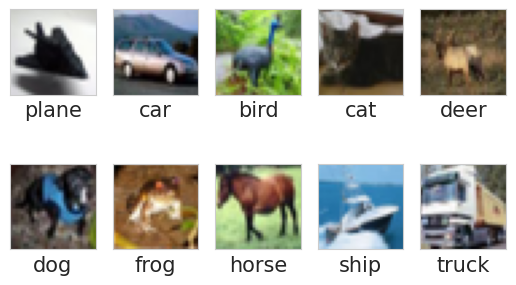

In [ ]:
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
fig, axes = plt.subplots(2, 5)
plt.subplots_adjust(top = 0.7)
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i].reshape((32,32,3)))
    i += 1

# Analytic gradient computation

In this work we will use Hinge loss function:
$$
Q_i = \sum\limits_{j!=y_i}^d
\begin{cases}
    0, s_{y_i} >= s_j + 1 \\
    s_j - s_{y_i} + 1, otherwise
\end{cases}\
= \sum\limits_{j!=y_i}^d {max(0, s_j - s_{y_i} + 1)}
$$
where $y_i$ is index for true class on image $i$, $s_j$ is prediction for class $j$.\
Loss for batch size $B$: $L = \frac{1}{B}\sum\limits_{i=1}^B{L_i}$\
Let us write the response of each class through the scalar product:
$$
Q_i =
\sum\limits_{j!=y_i}^d{max(0, s_j - s_{y_i} + 1)}=
\sum\limits_{j!=y_i}^d{max(0, w_{j}^T*x_i - w_{y_i}^T*x_i + Δ)}
$$\
where $w_j$ are weights corresponding to class $j$, $d$ is number of classes.\
Let's find gradient of Hinge loss function:
$$
\frac{\partial Q_i }{\partial w} =
\begin{bmatrix}
\frac{\partial Q_i }{\partial w_0}\\
\vdots\\
\frac{\partial Q_i }{\partial w_{y_i}}\\
\vdots\\
\frac{\partial Q_i }{\partial w_{d}}\\
\end{bmatrix}
=
\begin{bmatrix}
x_i \; or \; 0\\
\vdots\\
-\sum\limits_{j!=y_i}^d[\mathbb{1}(w_{j}^T*x_i - w_{y_i}^T*x_i + Δ > 0)] * x_i\\
\vdots\\
x_i \; or \; 0\\
\end{bmatrix}
$$


# Function for loss and accuracy visualization

In [ ]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

# Hinge loss fn and Hinge gradient fn

In [ ]:
def calc_hinge_loss(logits, y_true, delta = 1):
    """
    logits: predictions of model (batch).
    y_true: targets (batch).
    delta:  gap for hinge loss.
    """
    loss = 0
    # go through every element in batch.
    for i in range(len(logits)):
        # difference between true class and other classes.
        margins = torch.maximum(torch.tensor(0.0), logits[i] - logits[i][y_true[i]] + delta)
        margins[y_true[i]] = 0
        loss += torch.sum(margins)

    return loss / len(logits)

In [ ]:
def calc_hinge_grad(logits, X, y, delta = 1):
    """
    logits: predictions of model (batch).
    X: collection of objects (batch).
    y: collection of targets (batch).
    delta:  gap for hinge loss.
    """
    dW = torch.zeros((X.shape[1], logits.shape[1]))
    batch_size = X.shape[0]
    # go through every image in batch.
    for i in range(batch_size):
        true_class_logit = logits[i][int(y[i])]
        count_positive_margin = 0
        # go through logit for each class.
        for j in range(dW.shape[1]):
            if j == y[i]: continue
            margin = logits[i][j] - true_class_logit + delta
            if margin > 0:
                count_positive_margin += 1
                dW[:, j] += X[i]
        dW[:, y[i]] -= count_positive_margin * X[i]
    dW /= batch_size
    return dW

# Model training function

In [51]:
def train(num_epochs=1, lr=1e-4, bias=True):
    torch.manual_seed(42)
    train_losses = []
    w = torch.zeros((3072 + int(bias), len(classes)))

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = 0.0, 0.0
        for images, labels in tqdm(train_dataloader, desc='Training'):
            if bias:
                ones = torch.ones((images.shape[0], 1))
                images = torch.concatenate([images, ones], axis = 1)
            logits = torch.matmul(images,w)
            loss = calc_hinge_loss(logits=logits, y_true=labels)
            train_loss += loss.item()
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
            w = w - lr * calc_hinge_grad(logits, images, labels)

        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        val_loss, val_accuracy = 0.0, 0.0
        for images, labels in tqdm(val_dataloader, desc='Validating'):
            if bias:
                ones = torch.ones((images.shape[0], 1))
                images = torch.concatenate([images, ones], axis = 1)
            logits = torch.matmul(images,w)
            loss = calc_hinge_loss(logits=logits, y_true=labels)
            val_loss += loss.item()
            val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        val_loss /= len(val_dataloader)
        val_accuracy /= len(val_dataloader.dataset)
        val_losses += [val_loss]
        val_accuracies += [val_accuracy]
        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)
    return torch.min(torch.tensor(val_losses)), torch.max(torch.tensor(val_accuracies))

# Search of model hyperparameters

Let's try to train model without bias:

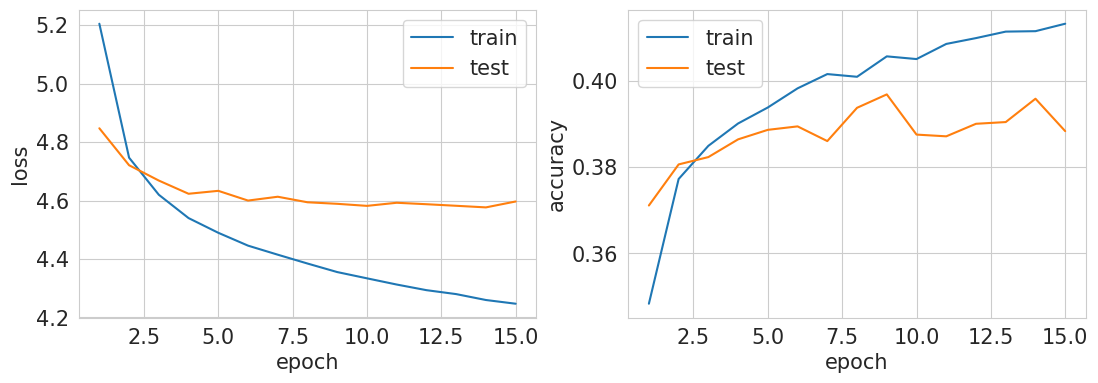

best val loss: 4.576498031616211, best val acc: 0.3968000113964081


In [52]:
best_val_loss, best_val_acc = train(num_epochs=15, bias=False)
print(f'best val loss: {best_val_loss}, best val acc: {best_val_acc}')

And with bias:

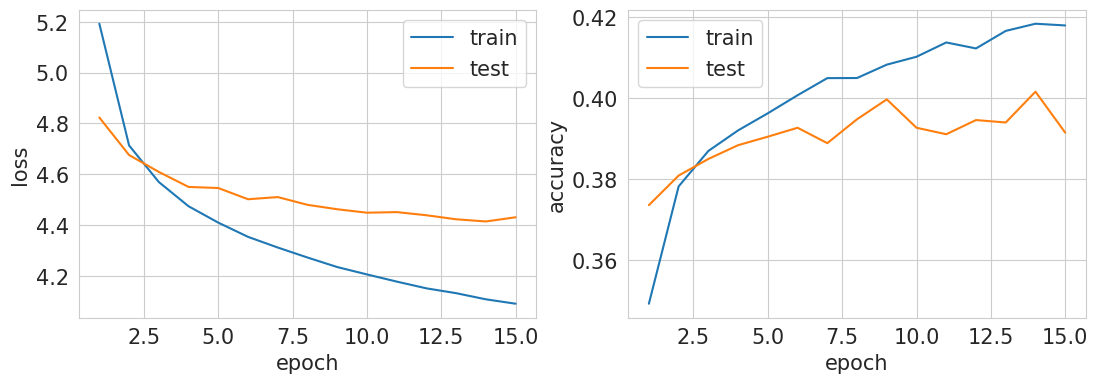

best val loss: 4.413701057434082, best val acc: 0.4016000032424927


In [53]:
best_val_loss, best_val_acc = train(num_epochs=15, bias=True)
print(f'best val loss: {best_val_loss}, best val acc: {best_val_acc}')